In [14]:
import json
import pandas as pd
import seaborn as sn
import numpy as np
import tensorflow as tf 
import argparse
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import multi_gpu_model
from keras.models import load_model
from CNN_LSTM_load_data import  generator_train, generator_test, generator_eval
from CNN_LSTM_split_data import generate_feature_train_list, generate_feature_test_list, generate_feature_eval_list
from CNN_LSTM_Train_tf import get_VGG16_base, get_LSTM_model

config = json.load(open('config/config.json'))
base_dir = config['base_dir']
history_dir = config["history_dir"]

base_image_dir = base_dir+"images/"
base_label_dir = base_dir+"labels/"
test_image_dir = base_image_dir + "test/"
test_label_dir = base_label_dir + "test/"
train_image_dir = base_image_dir + "train/"
train_label_dir = base_label_dir + "train/"
eval_image_dir = base_image_dir + "eval/"
eval_label_dir = base_label_dir + "eval/"

cnn_model_path = '../results/VGGSPLITLSTM/vgg16_model.h5'
lstm_model_path = '../results/VGGSPLITLSTM/vgg15_split_lstm_model.h5'

# 7 phases for surgical operation
class_labels = ["Preparation", "CalotTriangleDissection", "ClippingCutting", 
           "GallbladderDissection", "GallbladderPackaging", "CleaningCoagulation", "GallbladderRetraction"]

# Dimensions of input feature 
cnn_only = False
frames = 1 if cnn_only else 15    #Number of frames over which LSTM prediction happens
channels = 3  #RGB
rows = 224    
columns = 224 
BATCH_SIZE = 1 if cnn_only else 8


In [15]:
print(frames)

15


In [16]:
num_classes = len(class_labels)
video = Input(shape=(frames,rows,columns,channels))
#cnn_model = get_VGG16_base()
cnn_model = tf.keras.models.load_model(cnn_model_path)
#cnn_model.load_weights(cnn_model_path)
#l_model = get_LSTM_model(video, cnn_model)
#l_model.load_weights(lstm_model_path)
l_model = tf.keras.models.load_model(lstm_model_path)
#l_model.summary()

In [17]:
model = l_model
#model = cnn_model
optimizer = Nadam(lr=0.00001,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)

#softmax crossentropy
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["categorical_accuracy"]) 


In [18]:
validation_samples = generate_feature_eval_list(eval_image_dir, eval_label_dir)
validation_len = int(len(validation_samples)/(BATCH_SIZE*frames))
validation_len = (validation_len-2)*BATCH_SIZE*frames
validation_samples = validation_samples[0:validation_len]
print ("Validatation Length:{0}".format(validation_len))

Validatation Length:48360


In [ ]:
#define callback functions
#OuputImageCallback = CustomImageCallback( validation_generator, log_dir = './logs/Graph')

model_callbacks = [TensorBoard(log_dir='./logs/Graph', histogram_freq=5, write_graph=True, write_images=True, write_grads=True)]

# load data and predict
y = None
yhat = None
num_batches = int(len(validation_samples)/(BATCH_SIZE*frames))
print("Input count: {0}, Batch count: {1}".format(len(validation_samples), num_batches))

validation_generator = generator_eval(validation_samples, batch_size=BATCH_SIZE, frames_per_clip=frames, shuffle=False)
steps = 0
for x_batch, y_batch in validation_generator:
    steps+=1
    #print("Batch# {0}, Input shape {1}, X-Length {2}, gt shape {3}, Y-Length {4}".format(steps, np.shape(x_batch),len(x_batch[0]), np.shape(y_batch), len(y_batch)))
    if y is None:
        y = y_batch
    else: 
        y = np.concatenate((y, y_batch))

    # loss = lstm_model.evaluate_generator(validation_generator, steps=int(len(validation_samples)/(BATCH_SIZE*frames)), max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)
    if cnn_only:
        x_batch = x_batch[0]
    pred_batch = model.predict(x = x_batch, verbose=1)
    print(np.shape(pred_batch)) 
    if yhat is None:
        yhat = pred_batch
    else:
        yhat = np.concatenate((yhat, pred_batch))
    #yhat.append(pred_batch)
    if steps >= num_batches: break

yhat = np.argmax(yhat, axis=1)
y =  np.argmax(y, axis=1)

predfile = open('./logs/predictions_Yhat.txt', 'wt')
predfile.write('\r\n'.join(str(p).strip() for p in yhat))
predfile.close()

validationfile = open('./logs/input_X.txt', 'wt')
validationfile.write('\r\n'.join(str(s) for s in validation_samples))
validationfile.close()

gtfile = open('./logs/gt_Y.txt', 'wt')
gtfile.write('\r\n'.join(str(s) for s in y))
gtfile.close()

ytrue_labels = [class_labels[i] for i in y]
yhat_labels = [class_labels[i] for i in yhat]
print("ytrue_labels", ytrue_labels)
print("ypred_labels", yhat_labels)
#print("ground truth", [class_labels[i] for i in y])
#print("predictions", [class_labels[i] for i in yhat])

cm = confusion_matrix(y, yhat, labels = [0, 1, 2, 3, 4, 5, 6])
print(cm)

cr = classification_report(y, yhat, [0, 1, 2, 3, 4, 5, 6], class_labels)
print(cr)



In [ ]:
sn.heatmap(cm, cmap='Blues', annot=True, fmt="d")

In [2]:
cm = [[114,1,2,0,16,4,5],[18,505,583,62,75,172,3],[0,5,163,0,1,23,0],[18,32,201,330,90,233,0],[4,1,1,0,92,13,0],[29,1,16,9,42,219,5],[32,1,7,0,27,24,45]]

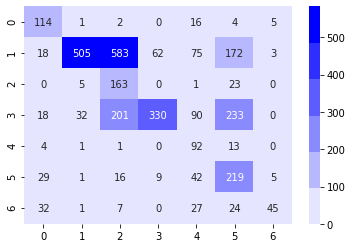

In [14]:
import seaborn as sn
custom = sn.light_palette("blue", reverse=False)
sn.heatmap(cm, cmap=custom, annot=True, fmt="d")

NameError: name 'num_classes' is not defined

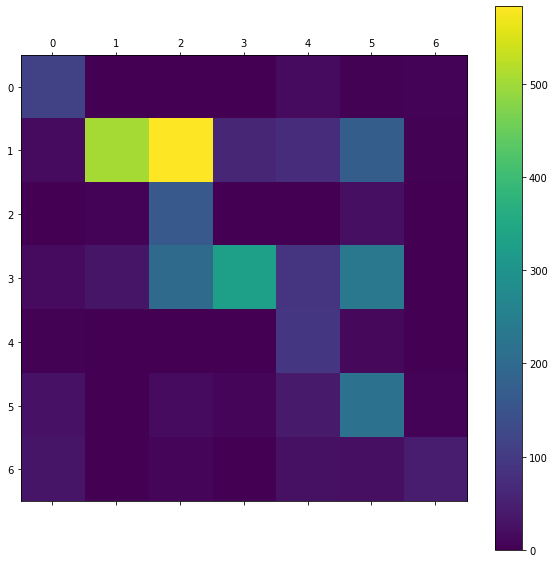

In [5]:
#print(cm)
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
#plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()